# Improving performance

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Learning curves

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
X, y = digits.data, digits.target

In [5]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [6]:
X.shape

(1797, 64)

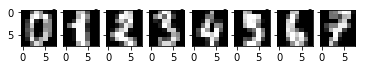

In [7]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [10]:
K.clear_session()

In [12]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [13]:
# store the initial random weights
initial_weights = model.get_weights()

In [14]:
y_cat = to_categorical(y, 10)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [17]:
X_train.shape

(1257, 64)

In [18]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [19]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

W0909 17:37:26.556737 10880 deprecation.py:323] From C:\Program Files\Python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Done size:  125
Done size:  502
Done size:  879
Done size:  1255


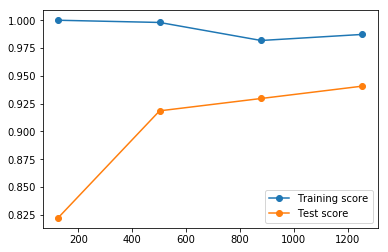

In [20]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

## Batch Normalization

In [21]:
from keras.layers import BatchNormalization

In [22]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [23]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [24]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [25]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

In [ ]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')


## Weight Regularization & Dropout

In [27]:
from keras.layers import Dropout

In [29]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])